In [1]:
# !pip install matplotlib
# !pip install sentencepiece

In [2]:
from datasets import load_dataset, Audio, DatasetDict, Dataset, load_from_disk, IterableDatasetDict, interleave_datasets, concatenate_datasets

from transformers import WhisperModel, WhisperFeatureExtractor, WhisperProcessor, WhisperForConditionalGeneration, GenerationConfig, WhisperTokenizer, logging, BitsAndBytesConfig, Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
# from peft import prepare_model_for_kbit_training, LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model
from huggingface_hub import notebook_login
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import multiprocess as mp
import gc
import time
import numpy as np
# import noisereduce as nr
from scipy import signal
import librosa
import evaluate
import jiwer
import os
import numba
from numba import jit, cuda
import torch.nn as nn


import torchaudio
from torch.nn import ZeroPad2d

from torch.utils.data import Dataset, DataLoader


In [4]:
from model import Processor, SpectroDataset, SpectrogramEncoder, UNetDecoder, STSAutoEncoder
from losses import MCDLoss, PerceptualLoss, ContrastiveLoss, AutoencoderLoss
# from trainer import Trainer  # Import Trainer from the external script
from evaluation import Evaluator

In [5]:

sampling_rate = 16000
max_input_length = 30.0
metric = evaluate.load("wer")
os.environ['KMP_DUPLICATE_LIB_OK']='True'
logging.set_verbosity_warning()

text_column_name = "normalized_text"

In [6]:
torch.cuda.empty_cache()
torch.set_num_threads(8)

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.version.cuda)

Using device: cuda
12.4


In [7]:
# notebook_login()

In [ ]:
# ds = IterableDatasetDict()
# ds["val"] = load_from_disk("StS_Nemo_CommonVoice_val.hf")
# ds["train"] = load_from_disk("StS_Nemo_CommonVoice_train.hf")

In [ ]:
# ds = IterableDatasetDict()

# ds = load_dataset("miosipof/StS_Nemo_CommonVoice")
# # datasets = datasets.rename_column("in_spectrogram", "input_features")
# # datasets = datasets.rename_column("sentence", "transcription")

# ds["train"] = ds["train"].cast_column("audio", Audio(sampling_rate=sampling_rate))
# ds["val"] = ds["val"].cast_column("audio", Audio(sampling_rate=sampling_rate))

# print(ds)

# ds["train"].save_to_disk("StS_Nemo_CommonVoice_train.hf")
# ds["val"].save_to_disk("StS_Nemo_CommonVoice_val.hf")

In [ ]:
# def set_torch(x):
#     x['in_spectrogram'] = torch.tensor(x['in_spectrogram'])
#     return x

# ds["val"] = ds["val"].map(set_torch)
# ds["train"] = ds["train"].map(set_torch)

# ds

In [ ]:
# ds = IterableDatasetDict()

# ds["train"] = load_dataset("miosipof/dysarthria_easycall", split="train")
# ds["train"] = ds["train"].cast_column("audio", Audio(sampling_rate=sampling_rate))

# text_column_name = "transcription"

# ds["train"] = ds["train"].remove_columns("gender")

# train_val_split = ds["train"].train_test_split(test_size=0.1)
# ds["train"] = train_val_split["train"]
# ds["val"] = train_val_split["test"]

# ds

In [ ]:
# !pip install nemo['all']
# !pip install git+https://github.com/NVIDIA/NeMo.git

In [9]:
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.modules import AudioToMelSpectrogramPreprocessor
from nemo.collections.asr.models import EncDecRNNTModel

# asr_model_id = "nvidia/stt_it_conformer_transducer_large"
asr_model_id = "nvidia/stt_en_conformer_transducer_large"

asr_model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(asr_model_id)


[NeMo I 2025-04-28 13:01:56 mixins:181] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-04-28 13:01:58 modelPT:180] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket1/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket2/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket3/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket4/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket5/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket6/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket7/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    

[NeMo I 2025-04-28 13:01:58 features:305] PADDING: 0
[NeMo I 2025-04-28 13:02:00 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}
[NeMo I 2025-04-28 13:02:00 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-04-28 13:02:00 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-04-28 13:02:00 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-04-28 13:02:00 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-04-28 13:02:01 save_restore_connector:275] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--stt_en_conformer_transducer_large/snapshots/a40623d1796368b64a9433bce3bcd75fce379a7b/stt_en_conformer_transducer_large.nemo.


In [11]:
asr_model.cfg.joint['fuse_loss_wer'] = False
asr_model.joint = EncDecRNNTModel.from_config_dict(asr_model.cfg.joint)
asr_model = asr_model.to(device)
asr_model.eval()

EncDecRNNTBPEModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConformerEncoder(
    (pre_encode): ConvSubsampling(
      (out): Linear(in_features=10240, out_features=512, bias=True)
      (conv): Sequential(
        (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pos_enc): RelPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-16): 17 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward1): ConformerFeedForward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (activation): Swish()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048,

In [12]:
asr_model.preprocessor

AudioToMelSpectrogramPreprocessor(
  (featurizer): FilterbankFeatures()
)

In [ ]:
# raw_datasets

In [ ]:
# raw_datasets = load_dataset("miosipof/STS_CommonVoice")
# train_val_split = raw_datasets["train"].train_test_split(test_size=0.1)

# raw_datasets["train"] = train_val_split["train"]
# raw_datasets["val"] = train_val_split["test"]

# # raw_datasets["train"] = load_from_disk("StS_CommonVoice_train.hf")
# # raw_datasets["val"] = load_from_disk("StS_CommonVoice_val.hf")
# # raw_datasets["test"] = load_from_disk("StS_CommonVoice_test.hf")



# # raw_datasets["train"] = raw_datasets["train"].select(range(2048))
# raw_datasets["val"] = raw_datasets["val"].select(range(2048))

# text_column_name = "sentence"

In [26]:
raw_datasets = load_dataset('ngdiana/uaspeech_severity_high')
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'target', 'path', 'dataset', 'severity', 'speech'],
        num_rows: 22524
    })
})

In [ ]:
# raw_datasets["train"] = raw_datasets["train"].filter(lambda x: x['speech_status'] == 'dysarthria')

In [14]:
from model import Processor

processor = Processor(asr_model=asr_model, device=device)

In [16]:
# asr_model.preprocessor.featurizer.preemph

In [27]:
asr_model.spec_augmentation = None  # 🔕 disables SpecAugment 

raw_datasets['train'].add_column('in_spectrogram',[0]*len(raw_datasets['train']))

def preprocess_dataset(batch):
    wfs = [x for x in batch["speech"]]
    S = processor.preprocess_nemo(wfs)
    batch["in_spectrogram"] = S
    return batch

In [28]:
raw_datasets["train"] = raw_datasets["train"].map(preprocess_dataset,batched=True,batch_size=1)

Map:   0%|          | 0/22524 [00:00<?, ? examples/s]

In [30]:
from huggingface_hub import create_repo
create_repo('miosipof/StS_UASpeech', repo_type='dataset')

RepoUrl('https://huggingface.co/datasets/miosipof/StS_UASpeech', endpoint='https://huggingface.co', repo_type='dataset', repo_id='miosipof/StS_UASpeech')

In [31]:
raw_datasets["train"].push_to_hub("miosipof/StS_UASpeech",split="train")

Uploading the dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/miosipof/StS_UASpeech/commit/58cf398383404a668fbfda9e9908781eb5e1e93d', commit_message='Upload dataset', commit_description='', oid='58cf398383404a668fbfda9e9908781eb5e1e93d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/miosipof/StS_UASpeech', endpoint='https://huggingface.co', repo_type='dataset', repo_id='miosipof/StS_UASpeech'), pr_revision=None, pr_num=None)

In [11]:
# # raw_datasets["test"].push_to_hub("miosipof/StS_Nemo_BB",split="test")

# split = raw_datasets["train"].train_test_split(test_size = 0.1)

# raw_datasets["test"] = split["test"]
# raw_datasets["train"] = split["train"]

# raw_datasets["test"].push_to_hub("miosipof/StS_Nemo_TORGO",split="test")
# raw_datasets["train"].push_to_hub("miosipof/StS_Nemo_TORGO",split="train")

In [19]:
# raw_datasets["test"]

In [20]:
# ds = load_dataset("miosipof/StS_Nemo_TORGO")
# ds

In [21]:
# ds["train"].save_to_disk("StS_Nemo_TORGO_train.hf")

In [27]:
idx = 1
x = ds["train"][idx]
wf = x["audio"]["array"]
wf = torch.tensor(wf).to(device)
wf = torch.stack([wf,wf], dim=0)
print(wf.shape)
S = processor.preprocess_nemo(wf)


print(S.shape)

torch.Size([2, 92736])
torch.Size([2, 80, 512])


In [28]:
S = S.float()

In [29]:
input_lengths = torch.full(
    size=(S.size(0),),  # batch size
    fill_value=S.size(-1),  # T
    dtype=torch.int64
).to(S.device)

encoder_out, encoded_len = processor.encode_nemo(S)

print(encoder_out.shape, encoded_len)

torch.Size([2, 512, 128]) tensor([128, 128], device='cuda:0')


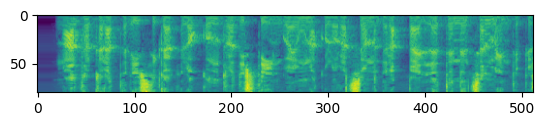

In [31]:
import matplotlib.pyplot as plt


plt.figure()
plt.imshow(S[0].detach().cpu().squeeze())
plt.show()

In [44]:

print(torch.min(S))
print(torch.max(S))
print(torch.mean(S))
print(torch.median(S))
print(torch.std(S))

S_min = torch.min(S).to(device)
S_max = torch.max(S).to(device)

tensor(-3.7981, device='cuda:0')
tensor(3.4988, device='cuda:0')
tensor(0.0479, device='cuda:0')
tensor(0.1117, device='cuda:0')
tensor(0.9863, device='cuda:0')


torch.Size([80, 512])


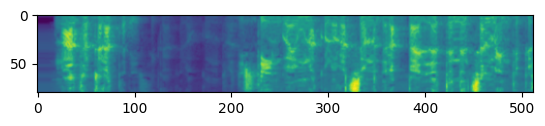

In [83]:
import cv2
import numpy as np
from PIL import Image

# img = Image.open("S_in.jpg")
# img = Image.open("S_timewarp.jpg")
# img = Image.open("S_blur.jpg")
# img = Image.open("S_freqwarp.jpg")
# img = Image.open("S_2dwarp.jpg")
img = Image.open("S_ampl.jpg")

# Convert to grayscale and resize to original spectrogram shape
img_gray = img.convert("L")  # 'L' mode = grayscale
img_resized = img_gray.resize((512, 80), Image.BILINEAR)

# Convert to numpy array and normalize to [0, 1]
spectrogram_img = np.array(img_resized) / 255.0

# Optional: flip vertically if it looks upside down (image origin is often top-left)
# spectrogram_img = np.flipud(spectrogram_img)

# Transpose to get shape (80, 512)
S_in = torch.tensor(spectrogram_img).to(device)

# Rescale to original dB range
S_in = S_in * (S_max - S_min) + S_min


print(S_in.shape)

S_in = S_in.float()
mel_tensor = torch.tensor(S_in).T.unsqueeze(0)  # shape (1, 80, 512)

plt.figure()
plt.imshow(S_in.detach().cpu().numpy())
plt.show()

In [60]:

print(torch.min(S_in))
print(torch.max(S_in))
print(torch.mean(S_in))
print(torch.median(S_in))
print(torch.std(S_in))


tensor(-2.8824, device='cuda:0', dtype=torch.float64)
tensor(1.9822, device='cuda:0', dtype=torch.float64)
tensor(-0.5233, device='cuda:0', dtype=torch.float64)
tensor(-0.5646, device='cuda:0', dtype=torch.float64)
tensor(0.5547, device='cuda:0', dtype=torch.float64)


In [50]:
from transformers import SpeechT5HifiGan

vocoder_id = "microsoft/speecht5_hifigan"
vocoder_model = SpeechT5HifiGan.from_pretrained(vocoder_id).to(device)

In [56]:
from IPython.display import Audio as AudioPlay

print("Original waveform:")
AudioPlay(wf.cpu().numpy(), rate=sampling_rate)

Original waveform:


In [67]:
with torch.no_grad():
    wf = vocoder_model(S[0].T).squeeze()  # shape (samples,)

print("Vocoded waveform:")
AudioPlay(wf.cpu().numpy(), rate=sampling_rate)

Vocoded waveform:


In [70]:
with torch.no_grad():
    wf = vocoder_model(mel_tensor).squeeze()  # shape (samples,)

print("Vocoded reconstructed waveform:")
AudioPlay(wf.cpu().numpy(), rate=sampling_rate)

Vocoded transformed waveform:


In [74]:
with torch.no_grad():
    wf = vocoder_model(mel_tensor).squeeze()  # shape (samples,)

print("Vocoded timewarp waveform:")
AudioPlay(wf.cpu().numpy(), rate=sampling_rate)

Vocoded timewarp waveform:


In [78]:
with torch.no_grad():
    wf = vocoder_model(mel_tensor).squeeze()  # shape (samples,)

print("Vocoded blur waveform:")
AudioPlay(wf.cpu().numpy(), rate=sampling_rate)

Vocoded blur waveform:


In [80]:
with torch.no_grad():
    wf = vocoder_model(mel_tensor).squeeze()  # shape (samples,)

print("Vocoded freqwarp waveform:")
AudioPlay(wf.cpu().numpy(), rate=sampling_rate)

Vocoded freqwarp waveform:


In [82]:
with torch.no_grad():
    wf = vocoder_model(mel_tensor).squeeze()  # shape (samples,)

print("Vocoded 2dwarp waveform:")
AudioPlay(wf.cpu().numpy(), rate=sampling_rate)

Vocoded 2dwarp waveform:


In [84]:
with torch.no_grad():
    wf = vocoder_model(mel_tensor).squeeze()  # shape (samples,)

print("Vocoded ampl waveform:")
AudioPlay(wf.cpu().numpy(), rate=sampling_rate)

Vocoded ampl waveform:


In [36]:
from model import STSAutoEncoder, STSTransformer, STSforCTCloss

encoder_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]

sts_transform = STSTransformer(encoder_channels=encoder_channels, temporal_channels=512, target_F=80,target_T=512)
encoder = torch.load("STS_Nemo_encoder_2.pth", map_location=device, weights_only=False) 
decoder = torch.load("STS_Nemo_decoder_2.pth", map_location=device, weights_only=False)

sts_transform.encoder.load_state_dict(encoder)
sts_transform.decoder.load_state_dict(decoder)

checkpoint = "STS_RNNT_Lite_TORGO_0_10_epochs.pth"
# checkpoint = "STS_RNNT_BB_2_2_epochs.pth"

transformer_weights = torch.load(checkpoint, map_location=device, weights_only=False)
sts_transform.transformer.load_state_dict(transformer_weights['model_state_dict']) 
sts_transform.to(device)

print(f"Transformer parameters: {sum(p.numel() for p in sts_transform.transformer.parameters() if p.requires_grad)}")

Encoder initialized
Decoder initialized
STSTransformer initialized
Transformer parameters: 5152434


In [26]:
# import torch.nn as nn

# # Check mode of all submodules
# for name, module in sts_rnnt.named_modules():
#     if isinstance(module, (nn.BatchNorm2d, nn.LayerNorm, nn.Dropout)):
#         print(f"{name} in eval mode? {not module.training}")


In [27]:
# sts_rnnt.eval()

In [28]:
# # Check mode of all submodules
# for name, module in sts_rnnt.named_modules():
#     if isinstance(module, (nn.BatchNorm2d, nn.LayerNorm, nn.Dropout)):
#         print(f"{name} in eval mode? {not module.training}")

In [20]:
text = ds["train"][idx]["transcription"]
target_token_ids = [processor.asr_model.tokenizer.text_to_ids(t) for t in text]
text


'Why yell or worry over silly items'

In [25]:
tokens_flattened = []
for token_seq in [target_token_ids]:
    token_seq_flattened = [torch.tensor(i, dtype=torch.int64) for ids in token_seq for i in ids]
    tokens_flattened.append(token_seq_flattened)

target_lengths = torch.tensor([len(token_seq_flattened) for token_seq_flattened in tokens_flattened], dtype=torch.int64)

tokens_flattened = torch.tensor(tokens_flattened)
tokens_flattened = torch.stack([tokens_flattened,tokens_flattened])
tokens_flattened = tokens_flattened.squeeze(1).to(device)
target_lengths = torch.stack([target_lengths,target_lengths])
target_lengths = target_lengths.squeeze(1).to(device)

target_lengths.shape, tokens_flattened.shape

(torch.Size([2]), torch.Size([2, 32]))

In [21]:
S = S.unsqueeze(1)
S.shape

torch.Size([2, 1, 80, 512])

In [ ]:
autoencoder = STSAutoEncoder(efficientnet_variant="efficientnet_b0", 
                 temporal_channels=512, 
                 reduced_channels=512, 
                 encoder_channels=encoder_channels, 
                 output_channels=1, 
                 target_F=80, 
                 target_T=512)

autoencoder.encoder.load_state_dict(encoder)
autoencoder.decoder.load_state_dict(decoder)
autoencoder = autoencoder.to(device)
autoencoder.eval()

In [27]:
def predict(x):

    
    input_lengths = torch.full(
        size=(x.size(0),),  # batch size
        fill_value=x.size(-1),  # T
        dtype=torch.long
    ).to(x.device)  


    encoder_out, encoded_len = asr_model(processed_signal=x.squeeze(1), processed_signal_length=input_lengths)

    hypotheses = asr_model.decoding.rnnt_decoder_predictions_tensor(
    encoder_output=encoder_out,
    encoded_lengths=encoded_len)
    
    return hypotheses

In [28]:
hypotheses = predict(S)
print([hyp.text for hyp in hypotheses])

['why yowler worry over silly items', 'why yowler worry over silly items']


In [29]:
S_id = autoencoder(S)
hypotheses = predict(S_id)
print([hyp.text for hyp in hypotheses])

['why yowl worry over silly items', 'why yowl worry over silly items']


In [38]:
asr_model.eval()
autoencoder.eval()

with torch.no_grad():
    S_new = sts_transform(S)
    hypotheses = predict(S_new)
    print([hyp.text for hyp in hypotheses])

['over three items', 'over three items']


In [68]:
S_new

tensor([[[[-0.3961, -0.5396, -0.9683,  ...,  0.0105,  0.0553,  0.1877],
          [-1.4858, -1.7343, -2.1687,  ...,  0.2780,  0.1130,  0.1670],
          [-1.6334, -1.8439, -2.5003,  ...,  0.2152,  0.1812,  0.1456],
          ...,
          [-0.9142, -0.8507, -1.0713,  ...,  0.2357,  0.0168,  0.1497],
          [-0.9241, -0.6752, -0.9811,  ...,  0.1739, -0.0540,  0.1517],
          [-0.7411, -0.4522, -0.5774,  ...,  0.0209, -0.0475, -0.0655]]],


        [[[-0.3926, -0.5358, -0.9611,  ...,  0.0088,  0.0547,  0.1867],
          [-1.4774, -1.7249, -2.1573,  ...,  0.2715,  0.1083,  0.1651],
          [-1.6222, -1.8357, -2.4874,  ...,  0.2127,  0.1793,  0.1438],
          ...,
          [-0.8821, -0.8370, -1.0568,  ...,  0.2312,  0.0160,  0.1448],
          [-0.9031, -0.6618, -0.9613,  ...,  0.1735, -0.0521,  0.1475],
          [-0.7185, -0.4352, -0.5659,  ...,  0.0134, -0.0537, -0.0709]]]],
       device='cuda:0')

In [84]:
import torch.nn.functional as F

def distil_feature_loss(S,identity=False):
    with torch.no_grad():
        input_lengths = torch.full(
            size=(S.size(0),),  # batch size
            fill_value=S.size(-1),  # T
            dtype=torch.long
        ).to(device)  
        enc_orig, _ = asr_model(processed_signal=S.squeeze(1), processed_signal_length=input_lengths)

    if identity == True:
        S_new = autoencoder(S)
    else:
        S_new, enc_orig, enc_trans, logits_orig, logits_trans  = sts_rnnt(S.to(device),tokens_flattened,target_lengths)
    
    enc_trans, _ = asr_model(processed_signal=S_new.squeeze(1), processed_signal_length=input_lengths)
    
    # Feature-level distillation
    loss_distill = F.mse_loss(enc_trans, enc_orig.detach())

    return loss_distill

In [85]:
print("Feature-distil loss, Identity:",distil_feature_loss(S,identity=True))
print("Feature-distil loss, Transformed:",distil_feature_loss(S,identity=False))

Feature-distil loss, Identity: tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)
Feature-distil loss, Transformed: tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)


In [86]:
def distil_logit_loss(S,identity=False):
    with torch.no_grad():
        input_lengths = torch.full(
            size=(S.size(0),),  # batch size
            fill_value=S.size(-1),  # T
            dtype=torch.long
        ).to(device)  
        enc_orig, _ = asr_model(processed_signal=S.squeeze(1), processed_signal_length=input_lengths)
        dec_orig, _, _ = asr_model.decoder(targets=tokens_flattened, target_length=target_lengths)

    if identity == True:
        S_new = autoencoder(S)
    else:
        S_new, enc_orig, enc_trans, logits_orig, logits_trans = sts_rnnt(S.to(device),tokens_flattened,target_lengths)
    
    enc_trans, _ = asr_model(processed_signal=S_new.squeeze(1), processed_signal_length=input_lengths)
    
    # Full ASR pass
    dec_trans, _, _ = asr_model.decoder(targets=tokens_flattened, target_length=target_lengths)

    logits_orig = asr_model.joint(encoder_outputs=enc_orig, decoder_outputs=dec_orig)
    logits_trans = asr_model.joint(encoder_outputs=enc_trans, decoder_outputs=dec_trans)
    
    loss_kl = F.kl_div(
        F.log_softmax(logits_trans, dim=-1),
        F.softmax(logits_orig.detach(), dim=-1),
        reduction='batchmean'
    )

    return loss_kl


In [87]:
print("Logit-distil loss, Identity:",distil_logit_loss(S,identity=True))
print("Logit-distil loss, Transformed:",distil_logit_loss(S,identity=False))

Logit-distil loss, Identity: tensor(0.9967, device='cuda:0', grad_fn=<DivBackward0>)
Logit-distil loss, Transformed: tensor(0.9102, device='cuda:0', grad_fn=<DivBackward0>)


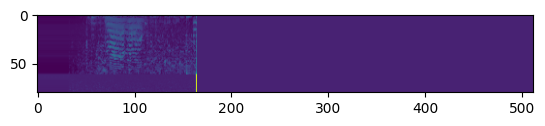

In [69]:
t0 = 0
t1 = 512

plt.figure()
plt.imshow(S[0].detach().cpu().squeeze()[:,t0:t1])
plt.show()

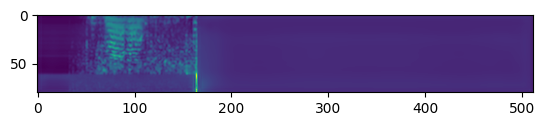

In [70]:
t0 = 0
t1 = 512

plt.figure()
plt.imshow(S_id[0].detach().cpu().squeeze()[:,t0:t1])
plt.show()

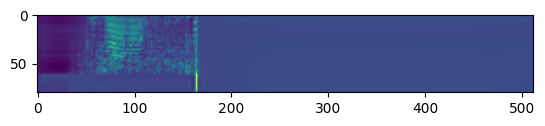

In [71]:
import matplotlib.pyplot as plt

t0 = 0
t1 = 512

plt.figure()
plt.imshow(S_new[0].detach().cpu().squeeze()[:,t0:t1])
plt.show()

In [49]:

class STSEvaluate:
    def __init__(self, model, loss_fn, val_dataset, batch_size):
        self.model = model
        self.loss_fn = loss_fn
        self.val_dataset = val_dataset
        self.batch_size = batch_size

    def evaluate(self,rank):
        self.model.asr_model.spec_augmentation = None  # 🔕 disables SpecAugment 
        self.model.asr_model.preprocessor = None  # Disable built-in preprocessing
        
        self.model = self.model.to(rank)
        loss_fn = self.loss_fn.to(rank)   
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size//2, shuffle=False, collate_fn=self.val_dataset.collate_fn)
        
        self.model.eval()
        # self.model.asr_model.eval()
        
        val_loss = 0
        val_feat_loss = 0
        val_conf_loss = 0
        val_mse_loss = 0
        val_mcd_loss = 0

        print(f"Starting evaluation on {len(val_loader)} batches")

        with torch.no_grad():
            for j, batch in enumerate(val_loader):         
                spectrograms, targets, target_lengths = batch 
                spectrograms = spectrograms.to(rank)
                spectrograms = spectrograms.unsqueeze(1)
                targets = targets.to(rank)
                target_lengths = target_lengths.to(rank)
            
                new_spectrograms, enc_orig, enc_trans, logits_orig, logits_trans = self.model(spectrograms,targets,target_lengths)
                            
                loss, loss_dict = loss_fn(
                    spectrograms,
                    new_spectrograms,
                    enc_orig,
                    enc_trans,
                    logits_orig,
                    logits_trans
                ) 
            
                val_loss += loss.item()
                val_feat_loss += loss_dict['feat'].item()
                val_conf_loss += loss_dict['conf'].item()
                val_mse_loss += loss_dict['mse'].item()
                val_mcd_loss += loss_dict['mcd'].item()
                
                loss_dict_detached = {}
                for k,v in loss_dict.items():
                    loss_dict_detached[k] = v.item()
                
                if (j+1)%10 == 0:
                    # print(f"Batch: {j}/{len(val_loader)}","Val loss:", np.round(val_loss/(j+1),3), np.round(100*j/(len(val_loader)),2),"%", flush=True)
                    print(f"{j}/{len(val_loader)}: {loss_dict}", flush=True)
                    
                torch.cuda.empty_cache()

        res = {
            "val_loss": val_loss/len(val_loader), 
            "val_feat_loss": val_feat_loss/len(val_loader), 
            "val_conf_loss": val_conf_loss/len(val_loader), 
            "val_mse_loss": val_mse_loss/len(val_loader), 
            "val_mcd_loss": val_mcd_loss/len(val_loader)
        }

        return res

In [50]:
from asr import SpeechDataset
from losses import IdentityLoss

val_dataset = SpeechDataset(ds["val"].select(range(1024)), asr_model, text_column_name="transcription")
batch_size = 16
loss_fn = IdentityLoss(lambda_mse=100.0, lambda_mcd=1.0, lambda_feat=5000.0, lambda_conf=5.0)

evaluator = STSEvaluate(sts_rnnt, loss_fn, val_dataset, batch_size)

evaluator.evaluate(device)


Starting evaluation on 128 batches
9/128: {'mse': tensor(129.1729, device='cuda:0'), 'mcd': tensor(12.7585), 'feat': tensor(8.8739, device='cuda:0'), 'conf': tensor(1.9468, device='cuda:0')}
19/128: {'mse': tensor(160.9618, device='cuda:0'), 'mcd': tensor(15.2606), 'feat': tensor(9.9061, device='cuda:0'), 'conf': tensor(2.4995, device='cuda:0')}
29/128: {'mse': tensor(107.7400, device='cuda:0'), 'mcd': tensor(12.3779), 'feat': tensor(4.9398, device='cuda:0'), 'conf': tensor(1.2600, device='cuda:0')}
39/128: {'mse': tensor(106.1357, device='cuda:0'), 'mcd': tensor(12.7768), 'feat': tensor(9.5543, device='cuda:0'), 'conf': tensor(2.4927, device='cuda:0')}
49/128: {'mse': tensor(106.1004, device='cuda:0'), 'mcd': tensor(11.9784), 'feat': tensor(6.4725, device='cuda:0'), 'conf': tensor(1.8297, device='cuda:0')}
59/128: {'mse': tensor(151.8329, device='cuda:0'), 'mcd': tensor(15.5375), 'feat': tensor(18.5095, device='cuda:0'), 'conf': tensor(4.8065, device='cuda:0')}
69/128: {'mse': tensor(

{'val_loss': 133.08075588941574,
 'val_feat_loss': 12.077045042067766,
 'val_conf_loss': 3.26208939217031,
 'val_mse_loss': 104.52958199381828,
 'val_mcd_loss': 13.212039589881897}

In [52]:
train_losses = {
    'loss': [310.1332299097202, 308.6351592901304], 
     'feat': [38.03339812344711, 37.880382250509676], 
     'conf': [264.2870159328054, 264.2495621393881], 
     'mse': [2.3223133365091937, 1.7375355619513555]    
}


val_losses = {
    'val_loss': [8.552346179574904, 7.6163284132648785], 
    'val_feat': [1.4066341248639886, 1.1912123873269942], 
    'val_conf': [0.3664798595910019, 0.3104564427995493], 
    'val_mse': [1.9379098657408118, 1.626763229198808], 
    'val_mcd': [4.84132232930052, 4.487896350000591]
}

In [ ]:

    
# def select_by_duration(x):
#     if len(x["audio"]["array"]) < 6*sampling_rate and len(x["audio"]["array"]) > 1*sampling_rate:
#         return True
#     else:
#         return False
        
# with torch.no_grad():
#     # datasets["test"] = datasets["test"].filter(select_by_duration)
#     datasets["val"] = datasets["val"].filter(select_by_duration)
#     datasets["train"] = datasets["train"].filter(select_by_duration)

In [ ]:
# from augmentation import Augment

# aug = Augment(dataset=dataset, synthetic_dataset=None, preprocessor=processor)

In [ ]:
# x = dataset[0]

# S = torch.tensor(x['input_features'])
# S.shape

In [ ]:
# x_new = aug.augment_sample(x)
# S_new = torch.tensor(x_new['input_features'])
# S.shape

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure()
# plt.imshow(S[:,:256])
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure()
# plt.imshow(S_new[:,:256])
# plt.show()

In [ ]:
# torch.set_num_threads(8)
# augmented_dataset = dataset.map(aug.augment_dataset)

In [ ]:
import torch.nn.functional as F


def preprocess(x):
    audio = x["audio"]
    wf_batch = [torch.tensor(a["array"],dtype=torch.float32) for a in audio]

    target_length = max(w.size(0) for w in wf_batch)
    wf_padded_batch = []
    
    for wf in wf_batch:
        pad_amount = target_length - wf.size(0)
        wf = F.pad(wf, (0, pad_amount), mode='constant', value=0)  # Pad on the right
        wf_padded_batch.append(wf)
        
    wf_padded_batch = torch.stack(wf_padded_batch, dim=0).to(device)
    S = processor.preprocess_nemo(wf_padded_batch)
        
    x["in_spectrogram"] = S

    return x



In [ ]:
ds["val"] = ds["val"].map(preprocess,batched=True,batch_size=32)
ds["train"] = ds["train"].map(preprocess,batched=True,batch_size=32)

In [ ]:
ds["train"].save_to_disk("StS_Nemo_EC_train.hf")
ds["val"].save_to_disk("StS_Nemo_EC_val.hf")


In [ ]:
ds["train"].push_to_hub("miosipof/StS_Nemo_EC",split="train")
ds["val"].push_to_hub("miosipof/StS_Nemo_EC",split="val")

In [ ]:
from model import SpectroDataset

In [ ]:
train_dataset = SpectroDataset(ds["train"],processor=processor,text_column_name="transcription")
val_dataset = SpectroDataset(ds["val"],processor=processor,text_column_name="transcription")

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=val_dataset.collate_fn)

In [ ]:
# for spectrograms, targets, target_lengths, transcriptions in train_loader:
#     print(spectrograms.shape, targets.shape, target_lengths, transcriptions)
#     break

In [ ]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated() / 1024**3, "GB allocated")
print(torch.cuda.memory_reserved() / 1024**3, "GB reserved")


In [ ]:
# Instantiate the encoder
encoder = SpectrogramEncoder(device, temporal_channels=512, reduced_channels=512)
encoder = encoder.to(device)

B = 1 # batch size

# Test with a dummy spectrogram (batch_size=1, channels=1, freq=128, time=256)
x = torch.randn(B, 1, 80, 512).to(device)  # (B, C, F, T)
E_f, E_t, encoder_hidden_states = encoder(x)

print(f"Spectral Features (E_f) Shape: {E_f.shape}")  # (B, 512 * F', T')
print(f"Temporal Features (E_t) Shape: {E_t.shape}")  # (B, temporal_channels, T')

print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters() if p.requires_grad)}")



In [ ]:
import torch
import torch.nn as nn





# Example Usage
F_target = 80  # Variable frequency resolution
T_target = 512  # Variable time resolution

encoder_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]

decoder = UNetDecoder(encoder_channels=encoder_channels, temporal_channels=512, target_F=F_target,target_T=T_target)
decoder = decoder.to(device)

# Test with dummy latent vectors (E_f, E_t) and EfficientNet skip connections
# E_f = torch.randn(4, 512, 16, 32)  # Spectral features from EfficientNet
# E_t = torch.randn(4, 128, 32)  # Temporal features from T-CNN
E_f = torch.randn(B, 1280, 3, 8).to(device)
E_t = torch.randn(B, 512, 8).to(device)

# encoder_features = [
#     torch.randn(16, 64, F_target, T_target),
#     torch.randn(16, 128, F_target // 2, T_target // 2),
#     torch.randn(16, 256, F_target // 4, T_target // 4),
#     torch.randn(16, 512, F_target // 8, T_target // 8)
# ]


# Run decoder
reconstructed_spectrogram = decoder(E_f, E_t, encoder_hidden_states)

print(f"Reconstructed Spectrogram Shape: {reconstructed_spectrogram.shape}")  # Expected (1, 1, F_target, T_target)
print(f"Decoder parameters: {sum(p.numel() for p in decoder.parameters() if p.requires_grad)}")


In [ ]:
# import torch
# import torch.nn as nn




# # Example Usage
# B, C_f, F, T = 16, 1280, 16, 32  # Example spectral feature dimensions
# B, C_t, T = 16, 512, 32  # Example temporal feature dimensions

# E_f = torch.randn(B, C_f, F, T)  # Spectral features
# E_t = torch.randn(B, C_t, T)  # Temporal features

# transformer = TimeFrequencyAttention()
# E_f_prime, E_t_prime = transformer(E_f, E_t)

# print(f"Transformed Spectral Shape: {E_f_prime.shape}")  # Expected (B, C_f, F, T)
# print(f"Transformed Temporal Shape: {E_t_prime.shape}")  # Expected (B, C_t, T)

# print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters() if p.requires_grad)}")


In [ ]:




batch_size = 4
S_orig = torch.randn(batch_size, 1, 80, 512).to(device)  # (B, C, F, T)



mcd_loss_fn = MCDLoss().to(device)
perceptual_loss_fn = PerceptualLoss(feature_extractor=processor).to(device)
contrastive_loss_fn = ContrastiveLoss(embedding_dim=1280).to(device)
loss_fn = AutoencoderLoss(perceptual_model=processor, decoder=decoder, embedding_dim=1280).to(device)

print(f"Contrastive loss trainable parameters: {sum(p.numel() for p in contrastive_loss_fn.parameters() if p.requires_grad)}")


# Forward pass: encoder
E_f, E_t, encoder_hidden_states = encoder(S_orig)
E_orig = loss_fn.concat_embeds(E_f,E_t)

print("E shape:",E_orig.shape)

# Generate `E_other` by shuffling within the batch
shuffle_indices = torch.randperm(batch_size)
E_other = E_orig[shuffle_indices]  # Uses different batch items as negatives

In [ ]:
# encoder_features = [
#     torch.randn(1, 64, F_target, T_target),
#     torch.randn(1, 128, F_target // 2, T_target // 2),
#     torch.randn(1, 256, F_target // 4, T_target // 4),
#     torch.randn(1, 512, F_target // 8, T_target // 8)
# ]

# for f in encoder_features:
#     print(f.shape)

In [ ]:

# Forward pass: decoder
S_recon = decoder(E_f, E_t, encoder_hidden_states)
E_f_recon, E_t_recon, _ = encoder(S_recon)



# # Test case A: base
# E_recon = concat_embeds(E_f_recon, E_t_recon)

# # Test case B: perfect match - zero-like loss expected
E_recon = E_orig.clone()

# # Test case C: distant embeddings - high loss expected
# E_recon = E_orig.clone() + torch.randn_like(E_orig) * 5.0

# # Test case D: small perturbations - intermediate loss expected
# E_recon = E_orig + torch.randn_like(E_orig) * 0.1


E_other = E_orig.clone() + torch.randn_like(E_orig) * 5.0

mcd_loss = mcd_loss_fn(S_orig,S_recon)
print(f"mcd_loss: {mcd_loss}")

perceptual_loss = perceptual_loss_fn(S_orig,S_recon)
print(f"perceptual_loss: {perceptual_loss}")

contrastive_loss = contrastive_loss_fn(E_orig, E_recon, E_other)
print(f"contrastive_loss: {contrastive_loss}")

In [ ]:
# total_loss, _, _, _, _ = loss_fn(S_orig, S_recon, E_orig, E_recon, E_other)
# print(f"total_loss: {total_loss}")

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import torch.distributed as dist
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, DistributedSampler
import gc
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

def train_autoencoder(
    encoder, decoder, train_loader, val_loader, perceptual_model, loss_fn,
    device="cuda", epochs=2, lr=1e-4
):
    """
    Train the autoencoder (Encoder + Decoder) using MSE, Perceptual, and Contrastive Loss.
    """
    
    encoder.to(device)
    decoder.to(device)

    losses = []
    val_losses = []
    
    # Define optimizer
    optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=1e-5)
    scheduler = ExponentialLR(optimizer, gamma=0.9)

    
    # Training loop
    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        running_loss = 0.0
        running_mse = 0.0
        running_mcd = 0.0
        running_perceptual = 0.0
        running_contrastive = 0.0
        
        start_time = time.time()
        
        for batch_idx, (S_orig, output_ids_padded, target_lengths, transcription) in enumerate(train_loader):
            S_orig = S_orig.to(device).unsqueeze(1)  # Original spectrograms (B, 1, F, T)

            # 🔹 Step 1: Forward Pass
            E_f, E_t, encoder_hidden_state = encoder(S_orig)  # Extract spectral & temporal features
            E_orig = loss_fn.concat_embeds(E_f,E_t)  # Combined latent representation

            S_recon = decoder(E_f, E_t, encoder_hidden_state)  # Reconstruct spectrogram
            E_f_recon, E_t_recon, _ = encoder(S_recon)
            E_recon = loss_fn.concat_embeds(E_f_recon, E_t_recon)

            # 🔹 Step 2: Prepare contrastive loss pairs
            batch_size = S_orig.shape[0]
            perm = torch.randperm(batch_size)
            E_other = E_orig[perm]  # Shuffle embeddings to create negative samples
            
            # 🔹 Step 3: Compute Loss
            loss, mse, mcd, perceptual, contrastive = loss_fn(S_orig, S_recon, E_orig, E_recon, E_other)  # Autoencoder loss

            losses.append(
                {
                    "loss": loss.item(),
                    "mse": mse.item(),
                    "mcd": mcd.item(),
                    "perceptual": perceptual.item(),
                    "contrastive": contrastive.item()
                }
            )
            
            # 🔹 Step 4: Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_mse += mse.item()
            running_mcd +=mcd.item()
            running_perceptual += perceptual.item()
            running_contrastive += contrastive.item()
            
            if batch_idx%100 == 0:
                print(f"Step {batch_idx}/{len(train_loader)}, epoch {epoch+1}: loss = {loss:.4f}, MSE {mse:.4f}, MCD {mcd:.4f}, perceptual {perceptual:.4f}, contrastive {contrastive:.4f}")             
            torch.cuda.empty_cache()
            
        val_loss = 0
        val_mse = 0.0
        val_mcd = 0.0
        val_perceptual = 0.0
        val_contrastive = 0.0    
        
        encoder.eval()
        decoder.eval()
        
        with torch.no_grad():
            for batch_idx, (S_orig, output_ids_padded, target_lengths, transcription) in enumerate(val_loader):
                S_orig = S_orig.to(device).unsqueeze(1)  # Original spectrograms (B, 1, F, T)
                # 🔹 Step 1: Forward Pass
                E_f, E_t, encoder_hidden_state = encoder(S_orig)  # Extract spectral & temporal features
                E_orig = loss_fn.concat_embeds(E_f,E_t)  # Combined latent representation
                S_recon = decoder(E_f, E_t, encoder_hidden_state)  # Reconstruct spectrogram
                E_f_recon, E_t_recon, _ = encoder(S_recon)
                E_recon = loss_fn.concat_embeds(E_f_recon, E_t_recon)
                # 🔹 Step 2: Prepare contrastive loss pairs
                batch_size = S_orig.shape[0]
                perm = torch.randperm(batch_size)
                E_other = E_orig[perm]  # Shuffle embeddings to create negative samples
                # 🔹 Step 3: Compute Loss
                loss, mse, mcd, perceptual, contrastive = loss_fn(S_orig, S_recon, E_orig, E_recon, E_other)  # Autoencoder loss     
                val_losses.append(
                    {
                        "loss": loss.item(),
                        "mse": mse.item(),
                        "mcd": mcd.item(),
                        "perceptual": perceptual.item(),
                        "contrastive": contrastive.item()
                    }
                )                
                val_loss += loss.item()       
                val_mse += mse.item()
                val_mcd +=mcd.item()
                val_perceptual += perceptual.item()
                val_contrastive += contrastive.item()
                if batch_idx%200 == 0:
                    print(f"Step {batch_idx}/{len(val_loader)}, epoch {epoch+1}: loss = {loss:.4f}, MSE {mse:.4f}, MCD {mcd:.4f}, perceptual {perceptual:.4f}, contrastive {contrastive:.4f}")
                    
        scheduler.step()
        
        torch.save(encoder.state_dict(), f"STS_Nemo_encoder_{epoch}.pth")
        torch.save(decoder.state_dict(), f"STS_Nemo_decoder_{epoch}.pth")

        
        # 🔹 Step 5: Print Training Stats
        avg_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Val loss: {avg_val_loss:.4f} - Time: {time.time() - start_time:.2f}s")
        print(f"Train MSE {running_mse/len(train_loader):.4f}, Train MCD {running_mcd/len(train_loader):.4f}, Train perceptual {running_perceptual/len(train_loader):.4f}, Train contrastive {running_contrastive/len(train_loader):.4f}")
        print(f"Val MSE {val_mse/len(val_loader):.4f}, Val MCD {val_mcd/len(val_loader):.4f}, Val perceptual {val_perceptual/len(val_loader):.4f}, Val contrastive {val_contrastive/len(val_loader):.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']}")
        
        gc.collect()
        torch.cuda.empty_cache()

    print("Training Complete!")

    return losses, val_losses, loss_fn



In [ ]:
# # Loss function
# lambda_mse=1.0
# lambda_mcd=0.03
# lambda_perceptual=1.0
# lambda_contrastive=1.0

# Loss function
lambda_mse= 100
lambda_mcd= 0.5
lambda_perceptual=1000
lambda_contrastive=2



loss_fn = AutoencoderLoss(perceptual_model=processor, 
                          decoder=decoder,
                          embedding_dim=1280, 
                          lambda_mse = lambda_mse, 
                          lambda_mcd = lambda_mcd, 
                          lambda_perceptual = lambda_perceptual, 
                          lambda_contrastive = lambda_contrastive
                         )

loss_fn.load_state_dict(torch.load('STS_Nemo_loss_2epochs.pth'))

loss_fn = loss_fn.to(device)
encoder = encoder.to(device)
decoder = decoder.to(device)
processor = processor.to(device)

num_epochs = 3

train_autoencoder(encoder, decoder, train_loader, val_loader, 
                  processor, loss_fn,
                  device="cuda", epochs=num_epochs, lr=1e-4)



In [ ]:
loss_fn

In [ ]:
loss_fn = loss_fn.to(device)

In [ ]:
torch.save(loss_fn, "STS_Nemo_loss_"+str(num_epochs)+".pth")

In [ ]:
torch.save(loss_fn.state_dict(), "STS_Nemo_loss_2epochs.pth")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, DistributedSampler
import torch
import torch.multiprocessing as mp







mp.set_start_method("spawn", force=True)  # Set start method to spawn


def start_training(model_name, model, loss_fn, train_dataset, val_dataset, lr=0.001, num_epochs=5, batch_size=32):
    world_size = torch.cuda.device_count()  # Number of available GPUs
    trainer = Trainer(model_name, model, loss_fn, train_dataset, val_dataset, batch_size, lr, num_epochs)  # Create an instance of Trainer    
    processes = []

    for rank in range(world_size):
        p = mp.Process(target=trainer.train, args=(rank, world_size))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()



# def start_evaluation(model, loss_fn, val_dataset, batch_size=32):
#     world_size = torch.cuda.device_count()  # Number of available GPUs
#     evaluator = Evaluator(model, loss_fn, val_dataset, batch_size)  # Create an instance of Trainer    
#     processes = []

#     for rank in range(world_size):
#         p = mp.Process(target=evaluator.run, args=(rank, world_size))
#         p.start()
#         processes.append(p)

#     for p in processes:
#         p.join()        

In [ ]:
model = STSAutoEncoder(efficientnet_variant="efficientnet_b0", 
                 temporal_channels=512, 
                 reduced_channels=512, 
                 encoder_channels=encoder_channels, 
                 output_channels=1, 
                 target_F=80, 
                 target_T=512)

# weights = torch.load("STS_AutoEncoder_4_epoch2.pth", map_location="cuda:0")
# model.load_state_dict(weights['model_state_dict'])  # Load trained weights
# loss_fn.load_state_dict(weights['loss_fn_state_dict'])

# batch_size=64
# lr=1e-4 
# num_epochs=1

# losses, val_losses, loss_fn = train_autoencoder(encoder, decoder, dataloader, val_dataloader, encode_whisper, loss_fn, epochs=2, lr=1e-4)


In [ ]:
torch.cuda.empty_cache()

# weights = torch.load("STS_AutoEncoder_6_epoch1.pth", map_location="cuda:0")
# model.load_state_dict(weights['model_state_dict'])  # Load trained weights
# loss_fn.load_state_dict(weights['loss_fn_state_dict'])

batch_size=16
lr=1e-3
num_epochs=1

start_training("STS_Nemo_AutoEncoder_1", model, loss_fn, train_dataset, val_dataset, lr=lr, num_epochs=num_epochs, batch_size=batch_size)

In [ ]:
# torch.cuda.empty_cache()

# loss_fn = torch.load("STS_AutoencoderLoss.pth")
# model.encoder = torch.load("STS_Encoder_1epochs.pth")
# model.decoder = torch.load("STS_Decoder_1epochs.pth")
# loss_fn.encoder = model.encoder
# loss_fn.decoder = model.decoder

# start_evaluation(model, loss_fn, val_dataset, batch_size=64)

In [ ]:
def evaluate_autoencoder(
    encoder, decoder, val_loader, perceptual_model, loss_fn
):
    """
    Train the autoencoder (Encoder + Decoder) using MSE, Perceptual, and Contrastive Loss.
    """
    encoder.to(device)
    decoder.to(device)
    
    encoder.eval()
    decoder.eval()
    
    loss_fn.eval()
 
    # Loss function
    

    running_loss = 0.0
    running_mse = 0.0
    running_mcd = 0.0
    running_perceptual = 0.0
    running_contrastive = 0.0
    
    with torch.no_grad():
        for batch_idx, (S_orig, output_ids_padded, target_lengths, transcription) in enumerate(val_loader):
            S_orig = S_orig.to(device)  # Original spectrograms (B, 1, F, T)
    
            # 🔹 Step 1: Forward Pass
            E_f, E_t, encoder_hidden_state = encoder(S_orig)  # Extract spectral & temporal features
            E_orig = loss_fn.concat_embeds(E_f,E_t)  # Combined latent representation
    
            S_recon = decoder(E_f, E_t, encoder_hidden_state)  # Reconstruct spectrogram
            S_recon = encoder.inverse_min_max_scaling(S_recon, 
                                                      encoder.sp_min, 
                                                      encoder.sp_max)
            
            E_f_recon, E_t_recon, _ = encoder(S_recon)
            E_recon = loss_fn.concat_embeds(E_f_recon, E_t_recon)
    
            # 🔹 Step 2: Prepare contrastive loss pairs
            batch_size = S_orig.shape[0]
            perm = torch.randperm(batch_size)
            E_other = E_orig[perm]  # Shuffle embeddings to create negative samples
            
            # 🔹 Step 3: Compute Loss
            loss, mse, mcd, perceptual, contrastive = loss_fn(S_orig, S_recon, E_orig, E_recon, E_other)  # Autoencoder loss
            
            running_loss += loss.item()
            running_mse += mse
            running_mcd +=mcd
            running_perceptual += perceptual
            running_contrastive += contrastive
            
            if batch_idx%10 == 0:
                print(f"Step {batch_idx}/{len(val_loader)}: loss = {loss:.4f}, MSE {mse:.4f}, MCD {mcd:.4f}, perceptual {perceptual:.4f}, contrastive {contrastive:.4f}")
    
    print("Evaluation Complete!")
    print(f"Total Val Loss: {running_loss/len(val_loader):.4f}")
    print(f"Val MSE {running_mse/len(val_loader):.4f}, MCD {running_mcd/len(val_loader):.4f}, perceptual {running_perceptual/len(val_loader):.4f}, contrastive {running_contrastive/len(val_loader):.4f}")


In [ ]:
weights = torch.load("STS_AutoEncoder_7_epoch1.pth", map_location="cuda:0")
model.load_state_dict(weights['model_state_dict'])  # Load trained weights
loss_fn.load_state_dict(weights['loss_fn_state_dict'])

model.to("cuda:0")  # Ensure it's on the correct device
processor.to("cuda:0")
loss_fn.to("cuda:0")

model.eval()  # Set to evaluation mode before inferenc
processor.eval()  # Set to evaluation mode before inferenc
loss_fn.eval()  # Set to evaluation mode before inferenc

# model = model.to(device)
# processor = processor.to(device)
# loss_fn = loss_fn.to(device)


evaluate_autoencoder(model.encoder, model.decoder, val_dataloader, processor, loss_fn)

In [ ]:



# 1 epoch MSE-only (with normalization)
# STS_AutoEncoder_MSE_0_epoch1.pth
# Total Val Loss: 0.0106
# Val MSE 0.0106, MCD 6.7912, perceptual 0.0259, contrastive 3.4606





In [ ]:
# 3 epochs
# STS_AutoEncoder_1_epoch1.pth:
# Val MSE 0.0024, MCD 3.3151, perceptual 0.0113, contrastive 0.7142

# 4 epochs
# STS_AutoEncoder_2_epoch0.pth
# Total Val Loss: 0.8676
# Val MSE 0.0025, MCD 3.3975, perceptual 0.0109, contrastive 0.7523

# 5 epochs
# Total Val Loss: 0.8884
# Val MSE 0.0025, MCD 3.4150, perceptual 0.0102, contrastive 0.7732

# 6 epochs
# Total Val Loss: 0.8986
# Val MSE 0.0025, MCD 3.4088, perceptual 0.0096, contrastive 0.7842

# STS_AutoEncoder_4_epoch2
# 8 epochs
# Total Val Loss: 0.8182
# Val MSE 0.0021, MCD 3.0984, perceptual 0.0083, contrastive 0.7149

# STS_AutoEncoder_5_epoch1.pth (normalized)
# Total Val Loss: 2.0753 (rebalanced)
# Val MSE 0.0062, MCD 4.8192, perceptual 0.0135, contrastive 0.7295

# STS_AutoEncoder_6_epoch1 (normalized)
# Total Val Loss: 0.2102  (rebalanced again)
# Val MSE 0.0063, MCD 5.1391, perceptual 0.0079, contrastive 0.7037

# STS_AutoEncoder_7_epoch1 (normalized)
# Total Val Loss: 0.1484 (rebalanced again)
# Val MSE 0.0029, MCD 3.3790, perceptual 0.0060, contrastive 0.7006

In [ ]:
idx = 1
processed_example = processor.preprocess_whisper(raw_datasets["train"][idx])
processed_example['in_spectrogram'] = processed_example['in_spectrogram'].to(device)
in_spectrogram = processed_example['in_spectrogram'][:,:,:,50:50+256]
in_spectrogram.shape

In [ ]:
AudioPlay(processed_example["audio"]["array"], rate=sampling_rate)

In [ ]:
t0 = 0
t1 = 256

plt.figure()
plt.imshow(in_spectrogram.detach().cpu().squeeze()[:,t0:t1])
plt.show()

In [ ]:
weights = torch.load("STS_AutoEncoder_7_epoch1.pth", map_location="cuda:0")
model.load_state_dict(weights['model_state_dict'])  # Load trained weights
loss_fn.load_state_dict(weights['loss_fn_state_dict'])

in_spectrogram = in_spectrogram.squeeze(0)
in_spectrogram = torch.stack([in_spectrogram]*16, dim=0)

in_spectrogram.shape

In [ ]:
from transformers import WhisperForConditionalGeneration
forced_decoder_ids = whisper_processor.get_decoder_prompt_ids(language="it", task="transcribe")
whisper_gen_model = WhisperForConditionalGeneration.from_pretrained(pretrained_model_id).to(device)

def greedy_generate(input_features):
    input_features = input_features.to(device)
    generated_ids = whisper_gen_model.generate(
        input_features,
        do_sample=False,  # Disable randomness
        num_beams=1,      # Greedy decoding
        temperature=0.0,   # No sampling
        forced_decoder_ids=forced_decoder_ids,  # Force Italian language token
    )
    transcription = whisper_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return transcription


In [ ]:
greedy_generate(in_spectrogram.squeeze(1))

In [ ]:

out_spectrogram = model(in_spectrogram)
out_spectrogram = model.encoder.inverse_min_max_scaling(out_spectrogram, 
                                                        encoder.sp_min, 
                                                        encoder.sp_max)
out_spectrogram.to(device)

plt.figure()
plt.imshow(out_spectrogram[0].detach().cpu().squeeze()[:,t0:t1])
plt.show()

In [ ]:
sp = out_spectrogram[0]


print(torch.min(sp))
print(torch.max(sp))
print(torch.mean(sp))
print(torch.median(sp))
print(torch.std(sp))


In [ ]:
out_encoded_example = processor.encode_whisper(out_spectrogram[0])
out_encoded_example

In [ ]:
greedy_generate(sp.squeeze(1))

In [ ]:
# !pip install sentencepiece
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
import sentencepiece

tts_model_id = "Sandiago21/speecht5_finetuned_voxpopuli_it"

tts_processor = SpeechT5Processor.from_pretrained(tts_model_id)
tts_model = SpeechT5ForTextToSpeech.from_pretrained(tts_model_id)
tts_vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

tts_spectrogram = out_spectrogram[0].squeeze(0).squeeze(1).transpose(1,0).detach().cpu()
print(tts_spectrogram.shape)

with torch.no_grad():
    speech = tts_vocoder(tts_spectrogram)


AudioPlay(speech, rate=sampling_rate)

In [ ]:
###########################################################################################
# AutoEncoder Model training
###########################################################################################

from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler

# Define training loop
def train_autoencoder_model(model, ctc_head, dataloader, val_dataloader, criterion, optimizer, num_epochs=20, freeze_epochs = 5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = []
    val_losses = []
    
    for epoch in range(num_epochs):

        # if epoch < freeze_epochs:
        #     # Freeze backbone layers
        #     for param in model.parameters():
        #         param.requires_grad = False
        #     print(f"Epoch {epoch + 1}: Freezing the CNN, training linear CTC head only.")
        # else:
        #     # Unfreeze backbone layers for fine-tuning
        #     for param in model.parameters():
        #         param.requires_grad = True
        #     print(f"Epoch {epoch + 1}: Fine-tuning the whole model.")

        for param in ctc_head.parameters():
            param.requires_grad = False
        print(f"Epoch {epoch + 1}: Freezing the CTC head, training CNN only.")
        
        model.train()
        running_loss = 0.0
    
        for batch_id, (spectrogram, output_ids_padded, target_lengths, transcription) in enumerate(dataloader):

            spectrogram = spectrogram.to(device)
            output_ids_padded = output_ids_padded.to(device)
            target_lengths = target_lengths.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            transformed_spectrogram = model(spectrogram)
            # transformed_spectrogram = spectrogram

            # Pass transformed spectrograms to Whisper encoder
            encoder_hidden_states = whisper_encoder(transformed_spectrogram.squeeze(1)).last_hidden_state

            target_lengths = target_lengths.to(device)

            # Pass through CTC head
            logits = ctc_head(encoder_hidden_states)  # (batch, 1500, vocab_size)

            input_lengths = torch.full((len(logits),), logits.shape[1], dtype=torch.long).to(device)

            loss = criterion(logits.permute(1, 0, 2), output_ids_padded, input_lengths, target_lengths)  # Permute for CTC loss

            loss.backward()
            optimizer.step()        

            running_loss += loss.item()

            if batch_id%100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}: {round(100*batch_id/len(dataloader))}%. Batch loss = {loss.item():.4f}")

        
        scheduler.step()
        val_loss = 0.0
        
        for batch_id, (spectrogram, output_ids_padded, target_lengths, transcription) in enumerate(val_dataloader):

            spectrogram = spectrogram.to(device)
            output_ids_padded = output_ids_padded.to(device)
            target_lengths = target_lengths.to(device)

            with torch.no_grad():  # No need to compute gradients
                transformed_spectrogram = model(spectrogram)
                # transformed_spectrogram = spectrogram
                encoder_hidden_states = whisper_encoder(transformed_spectrogram.squeeze(1)).last_hidden_state
                logits = ctc_head(encoder_hidden_states)
                input_lengths = torch.full((len(logits),), logits.shape[1], dtype=torch.long).to(device)
                target_lengths = target_lengths.to(device)
                vloss = criterion(logits.permute(1, 0, 2), output_ids_padded, input_lengths, target_lengths)  # Permute for CTC loss
                val_loss += vloss.item()

        
        epoch_loss = running_loss/len(dataloader)
        val_loss = val_loss/len(val_dataloader)

        losses.append(epoch_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']}")

    print("Training complete")
    return losses, val_losses



In [ ]:
##################################################################################################

free, total = torch.cuda.mem_get_info()
alloc = torch.cuda.max_memory_allocated()
print(
f"Total GPU memory {total/(1024**3):.1f} GB,"
f" alloc {alloc/(1024**3):.1f} GB,"
f" free {free/(1024**2)}MB ({free / total * 100:.3f}%)"
)


autoencoder_model = STSAutoEncoder()
# autoencoder_model.encoder = torch.load("sts_AutoEncoder_v4_2_epochs.pth")
autoencoder_model = autoencoder_model.to(device)


ctc_head = BiLSTM_CTCHead().to(device)
ctc_head = torch.load("BiLSTM_CTCHead_v4_2_epochs.pth")
ctc_head = ctc_head.to(device)

# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = nn.CTCLoss()

# Set Adam optimizer
# optimizer = torch.optim.AdamW(autoencoder_model.parameters(), lr=3e-5, weight_decay=1e-4)
optimizer = torch.optim.Adam(list(autoencoder_model.parameters()) + list(ctc_head.parameters()), lr=1e-3, weight_decay=1e-4)

scheduler = ExponentialLR(optimizer, gamma=0.9)


total_params = sum(p.numel() for p in autoencoder_model.parameters())
trainable_params = sum(p.numel() for p in autoencoder_model.parameters() if p.requires_grad)
trainable_percent = round(100*trainable_params/total_params)
print(f"CNN Total params: {total_params}, trainable: {trainable_params} ({trainable_percent}%)")

total_params = sum(p.numel() for p in ctc_head.parameters())
trainable_params = sum(p.numel() for p in ctc_head.parameters() if p.requires_grad)
trainable_percent = round(100*trainable_params/total_params)
print(f"FC Total params: {total_params}, trainable: {trainable_params} ({trainable_percent}%)")

# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=0.001,         # Start with a lower learning rate
#     betas=(0.9, 0.999), # Beta settings to control momentum
#     weight_decay=1e-4  # Regularization
# )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Train model
losses, val_losses = train_autoencoder_model(autoencoder_model, 
                                             ctc_head, 
                                             dataloader, 
                                             val_dataloader, 
                                             criterion, 
                                             optimizer, 
                                             num_epochs=3, 
                                             freeze_epochs=0)



free, total = torch.cuda.mem_get_info()
alloc = torch.cuda.max_memory_allocated()
print(
f"Total GPU memory {total/(1024**3):.1f} GB,"
f" alloc {alloc/(1024**3):.1f} GB,"
f" free {free/(1024**2)}MB ({free / total * 100:.3f}%)"
)

In [ ]:
torch.save(autoencoder_model,"sts_AutoEncoder_UNet_1_epochs.pth")
# torch.save(ctc_head,"BiLSTM_CTCHead_v4_5_epochs.pth")


In [ ]:
# torch.save(autoencoder_model.encoder,"sts_encoder_10epochs.pth")
# torch.save(ctc_head,"BiLSTM_CTCHead_10epochs.pth")


In [ ]:
ctc_head = BiLSTM_CTCHead().to(device)
ctc_head = torch.load("BiLSTM_CTCHead_v4_4_epochs.pth")
ctc_head = ctc_head.to(device)

In [ ]:
import evaluate
from jiwer import wer
import re
metric = evaluate.load("wer")

def greedy_decode(input_features, whisper_model, whisper_processor):
    """Perform greedy decoding (num_beams=1, temperature=0.0)"""
    forced_decoder_ids = whisper_processor.get_decoder_prompt_ids(language="it", task="transcribe")
    input_features = input_features.to(device) 
    generated_ids = whisper_model.generate(
        input_features,
        do_sample=False,  # Disable randomness
        num_beams=1,      # Greedy decoding
        temperature=0.0,   # No sampling
        forced_decoder_ids=forced_decoder_ids,  # Force Italian language token
    )
    transcription = whisper_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return transcription


def normalize_text(text):
    """Standardize text (lowercase, remove punctuation, trim spaces)"""
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text

In [ ]:
def evaluation(model,ctc_head,dataloader):
    model.eval()
    ctc_head.eval()
    
    blank_counts = []
    total_counts = []
    
    base_preds = []
    new_preds = []
    references = []
    
    with torch.no_grad():
        for batch_id, (spectrogram, output_ids_padded, target_lengths, transcription) in enumerate(dataloader):
            
            spectrogram = spectrogram.to(device)
            output_ids_padded = output_ids_padded.to(device)
            target_lengths = target_lengths.to(device)

            transformed_spectrogram = model(spectrogram)
            
            # Forward pass through Whisper encoder
            encoder_hidden_states = whisper_encoder(transformed_spectrogram.squeeze(1)).last_hidden_state

            # Get CTC logits
            logits = ctc_head(encoder_hidden_states)  # (batch, seq_len, vocab_size)
            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)  # CTC expects log probs

            # Blank token domination check
            # Get most likely token per timestep
            predicted_tokens = torch.argmax(log_probs, dim=-1)  # (batch, seq_len)
            # Count occurrences of the blank token (index 0)
            blank_counts.extend((predicted_tokens == 0).sum(dim=1).cpu().numpy())
            total_counts.extend(predicted_tokens.shape[1] * torch.ones(predicted_tokens.shape[0]).cpu().numpy())

            # Generate autoregressively with whisper decoder

            for i in range(spectrogram.size(0)):
                
                
                base_s = spectrogram[i,:,:,:]
                base_pred_text = greedy_decode(base_s.squeeze(1), whisper_model, whisper_processor)
                base_pred_text = normalize_text(base_pred_text)
                
                new_s = transformed_spectrogram[i,:,:,:]
                new_pred_text = greedy_decode(new_s.squeeze(1), whisper_model, whisper_processor)
                new_pred_text = normalize_text(new_pred_text)
                
                ref_text = normalize_text(transcription[i])
        
                # Store results
                base_preds.append(base_pred_text)
                new_preds.append(new_pred_text)
                references.append(ref_text)

                if batch_id%5 == 0 and i == 0:
                    print(f"{100*round(batch_id/len(dataloader),2)}%")
                    print(f" Base: {base_pred_text} \n New: {new_pred_text} \n Ref: {ref_text} \n\n")
                    

    # # Convert to numpy
    # blank_counts = torch.tensor(blank_counts, dtype=torch.float32)
    # total_counts = torch.tensor(total_counts, dtype=torch.float32)

    # # Compute blank token ratio
    # blank_ratios = blank_counts / total_counts

    # # Plot distribution of blank ratios
    # plt.hist(blank_ratios.cpu().numpy(), bins=20, alpha=0.75)
    # plt.xlabel("Blank Token Ratio")
    # plt.ylabel("Number of Samples")
    # plt.title("Distribution of Blank Token Usage in CTC Output")
    # plt.grid(True)
    # plt.show()

    # # Print summary statistics
    # print(f"Mean blank token ratio: {blank_ratios.mean().item():.4f}")
    # print(f"Max blank token ratio: {blank_ratios.max().item():.4f}")
    # print(f"Min blank token ratio: {blank_ratios.min().item():.4f}")   

    return base_preds, new_preds, references


    
base_preds, new_preds, references = evaluation(autoencoder_model,ctc_head,val_dataloader)

# Compute WER
base_wer_score = metric.compute(predictions=base_preds, references=references)
new_wer_score = metric.compute(predictions=new_preds, references=references)
print(f"Base WER: {100*base_wer_score:.1f} \n New WER: {100*new_wer_score:.1f}")

In [ ]:
idx = 2


x = raw_datasets["val"][idx]

base_s = torch.tensor(x["in_spectrogram"])

base_s.shape

In [ ]:
x[text_column_name]

In [ ]:
base_pred_text = greedy_decode(base_s.squeeze(1), whisper_model, whisper_processor)
base_pred_text

In [ ]:
import matplotlib.pyplot as plt

t0 = 0
t1 = 1200

plt.figure()
plt.imshow(base_s.detach().numpy().squeeze()[:,t0:t1])
plt.show()

In [ ]:
new_s = autoencoder_model(base_s.to(device))

new_pred_text = greedy_decode(new_s.squeeze(1), whisper_model, whisper_processor)
new_pred_text

In [ ]:
plt.figure()
plt.imshow(new_s.squeeze().detach().cpu().numpy()[:,t0:t1])
plt.show()

In [ ]:
from IPython.display import Audio as AudioPlay
import matplotlib.pyplot as plt

# audio_path = "/workspace/PASR/audio_test/QUANDO CI VEDIAMO DI NUOVO.wav"
# # audio_path = "/workspace/PASR/audio_test/grazie_ciao.wav"

# waveform, sr = torchaudio.load(audio_path)
# if sr != sampling_rate:
#     waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sampling_rate)(waveform).to(device)
# waveform = waveform.detach().cpu()
# waveform = waveform[0]



##### TRY TO OVERFIT:
sample = raw_datasets["train"][11]
waveform = sample["audio"]["array"]
preprocessed_sample = prepare_dataset(sample)
input_spectrogram = preprocessed_sample['labels']
input_spectrogram = torch.tensor(input_spectrogram[0],dtype=torch.float32).T.unsqueeze(0).unsqueeze(0).to(device)

AudioPlay(waveform, rate=sampling_rate)


In [ ]:
input_spectrogram.shape

In [ ]:

print(f"INPUT: {input_spectrogram.shape,input_spectrogram.min(),input_spectrogram.max(),input_spectrogram.mean(),input_spectrogram.std()}")

model.eval()
output_spectrogram = model(spectro_norm(input_spectrogram))
# output_spectrogram = (1 + spectro_norm(output_spectrogram))/2

print(f"OUTPUT: {output_spectrogram.shape,output_spectrogram.min(),output_spectrogram.max(),output_spectrogram.mean(),output_spectrogram.std()}")


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(input_spectrogram.squeeze().detach().cpu())
plt.show()

In [ ]:
plt.figure()
plt.imshow(output_spectrogram.squeeze().detach().cpu())
plt.show()

In [ ]:
time = 100
input_slice = input_spectrogram.squeeze()[:,time].detach().cpu().numpy() # slice non-silent timeframe
plt.plot(range(len(input_slice)),input_slice)

In [ ]:
output_slice = output_spectrogram.squeeze()[:,time].detach().cpu().numpy() # slice non-silent timeframe
plt.plot(range(len(output_slice)),output_slice)

In [ ]:
# output_spectrogram.squeeze()[:,:5 ] # 5 first timesteps

In [ ]:
with torch.no_grad():
    speech = vocoder(input_spectrogram.squeeze().T)

AudioPlay(speech.detach().cpu().numpy(), rate=sampling_rate)

In [ ]:
with torch.no_grad():
    speech = vocoder(output_spectrogram.squeeze().T)

AudioPlay(speech.detach().cpu().numpy(), rate=sampling_rate)

In [ ]:
adaptive_pool = nn.AdaptiveAvgPool2d((140, 80))

input_spectrogram_downsampled = input_spectrogram.squeeze(0).transpose(1,2)/3
print(f"INPUT SQUEEZED: {input_spectrogram_downsampled.shape}")
input_spectrogram_downsampled = adaptive_pool(input_spectrogram_downsampled).squeeze()
print(f"DOWNSAMPLED: {input_spectrogram_downsampled.shape}")

wf = vocoder(input_spectrogram_downsampled)
AudioPlay(wf.detach().cpu(), rate=sampling_rate)

In [ ]:
# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(input_spectrogram.squeeze().cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Amplitude")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequencies")
plt.title("Input spectrogram 128x4000")
plt.show()

In [ ]:
# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(input_spectrogram_downsampled.squeeze().cpu().numpy().transpose(), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Amplitude")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequencies")
plt.title("Input spectrogram 80x140")
plt.show()

In [ ]:



model.eval()
predicted_spectrogram = model(input_spectrogram)
print(f"OUTPUT: {predicted_spectrogram.shape}")


spectrogram_resized_freq = F.avg_pool2d(predicted_spectrogram, kernel_size=(1, 4), stride=(1, 4))
spectrogram_resized_time = F.adaptive_avg_pool2d(spectrogram_resized_freq, output_size=(80, 1024))

print(f"DOWNSAMPLED: {spectrogram_resized_time.shape}")

predicted_waveform = vocoder(spectrogram_resized_time.squeeze().transpose(0,1))
# AudioPlay(predicted_waveform.detach().cpu(), rate=sampling_rate)

In [ ]:
predicted_waveform.shape

In [ ]:
asr_model_id = "mattiasu96/whisper-tiny-it"

asr_model = WhisperForConditionalGeneration.from_pretrained(asr_model_id).to(device)
asr_processor = WhisperProcessor.from_pretrained(asr_model_id, language="it", task="transcribe")

# Whisper expects the input as a dictionary with 'input_features' key
inputs = asr_processor(predicted_waveform.unsqueeze(0).detach().cpu().numpy(), return_tensors="pt").to(device)

print(inputs)

# Forward pass through Whisper model (no need for decoder_input_ids)
predicted_ids = asr_model.generate(inputs.input_features)

# Decode the logits into text (transcription)
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

print(transcription)

In [ ]:
###########################################################################################
# STS Model training
###########################################################################################

from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Define training loop
def train_sts_model(model, dataloader, val_dataloader, criterion, optimizer, num_epochs=20, freeze_epochs = 5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = []
    val_losses = []
    
    for epoch in range(num_epochs):

        # if epoch < freeze_epochs:
        #     # Freeze backbone layers
        #     for param in model.backbone.parameters():
        #         param.requires_grad = False
        #     print(f"Epoch {epoch + 1}: Freezing the backbone.")
        # else:
        #     # Unfreeze backbone layers for fine-tuning
        #     for param in model.backbone.parameters():
        #         param.requires_grad = True
        #     print(f"Epoch {epoch + 1}: Fine-tuning the whole model.")
        
        model.train()
        running_loss = 0.0
    
        for batch_id, (spectrogram,target) in enumerate(dataloader):

            spectrogram = torch.exp(spectrogram)
            target = torch.exp(target)
            spectrogram = spectro_norm(spectrogram).to(device)
            target = spectro_norm(target).to(device)

            spectrogram = spectrogram.to(torch.float32).unsqueeze(1) # add channel dim
            target = target.to(torch.float32).unsqueeze(1) # add channel dim

            # print(f"input: {spectrogram.shape}")
            # print(f"target: {target.shape}")
            

            # Zero the gradients
            optimizer.zero_grad()

            with autocast():  # Automatically use FP16 where possible
                # spectrogram = spectrogram.repeat(1, 3, 1, 1) 
                outputs = model(spectrogram)
                # print(f"Outputs: {outputs.shape}. Targets: {target.shape}")
                loss = criterion(outputs, target)


            # Backward pass with GradScaler
            scaler.scale(loss).backward()

            # Update weights with GradScaler
            scaler.step(optimizer)
    
            # Update GradScaler after step
            scaler.update()          

            running_loss += loss.item()

            if batch_id%50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}: {round(100*batch_id/len(dataloader))}%. Batch loss = {loss.item():.4f}")

        scheduler.step()
        
        val_correct_predictions = 0
        val_total_predictions = 0
        val_loss = 0.0
        model.eval()
        for spectrogram, target in val_dataloader:
            spectrogram = torch.exp(spectrogram)
            spectrogram = spectro_norm(spectrogram).to(device)
            target = spectro_norm(target).to(device)

            spectrogram = spectrogram.to(torch.float32).unsqueeze(1) # add channel dim
            target = target.to(torch.float32).unsqueeze(1) # add channel dim

            with torch.no_grad():  # No need to compute gradients
                with autocast():  # Use FP16 for inference            
                    # spectrogram = spectrogram.repeat(1, 3, 1, 1)
                    outputs = model(spectrogram)
                    loss = criterion(outputs, target)
                    val_loss += loss.item()
        
        epoch_loss = running_loss/len(dataloader)
        val_loss = val_loss/len(val_dataloader)

        losses.append(epoch_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']}")

    print("Training complete")
    return losses, val_losses

##################################################################################################

free, total = torch.cuda.mem_get_info()
alloc = torch.cuda.max_memory_allocated()
print(
f"Total GPU memory {total/(1024**3):.1f} GB,"
f" alloc {alloc/(1024**3):.1f} GB,"
f" free {free/(1024**2)}MB ({free / total * 100:.3f}%)"
)


del model
gc.collect()

model = STSNet().to(device)
# criterion = nn.MSELoss()
criterion = nn.L1Loss()

# Set Adam optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_percent = round(100*trainable_params/total_params)
print(f"Total params: {total_params}, trainable: {trainable_params} ({trainable_percent}%)")


# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=0.001,         # Start with a lower learning rate
#     betas=(0.9, 0.999), # Beta settings to control momentum
#     weight_decay=1e-4  # Regularization
# )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Train model
losses, val_losses = train_sts_model(model, dataloader, val_dataloader, criterion, optimizer, num_epochs=10, freeze_epochs=15)



free, total = torch.cuda.mem_get_info()
alloc = torch.cuda.max_memory_allocated()
print(
f"Total GPU memory {total/(1024**3):.1f} GB,"
f" alloc {alloc/(1024**3):.1f} GB,"
f" free {free/(1024**2)}MB ({free / total * 100:.3f}%)"
)